In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

NOTE: Significant amounts of this code have been adopted from Kotliar et al, Cell 2020 - namely running MAST on a scanpy adata object. Please cite the orignial authors if using Dylan's MAST code.

In [2]:
adata_allcells = sc.read_h5ad("./adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    var

In [3]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['CoarseClustering'].isin(['Macrophages']), :]
adata

View of AnnData object with n_obs × n_vars = 22037 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [2]:
import os
adir = "./Excel_sheets/MAST_DE_Macrophage_Outputs"
project_name = 'File_NEW'
gcs = False
abase = os.path.join(adir, project_name)
results_dir = './Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs'

In [3]:
dedir = os.path.join(adir, 'DE_Stage')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [4]:
import palettable
from IPython.display import display
from joblib import parallel_backend
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from matplotlib import gridspec

In [9]:
adata_raw=adata
set(list(adata.obs.Subclustering))


{'C1QB$^{hi}$, C1QA$^{hi}$ Mφ',
 'CXCL9$^{hi}$, IDO1$^{hi}$ Mφ',
 'FABP4$^{hi}$, MCEMP1$^{hi}$ Alveolar Mφ',
 'LGALS3$^{hi}$, FN1$^{hi}$ Mφ',
 'S100A4$^{hi}$, CFP$^{hi}$ Monocytes',
 'THBS1$^{hi}$, FCN1$^{hi}$ Mφ'}

In [10]:
labmap = {
'C1QB$^{hi}$, C1QA$^{hi}$ Mφ':"C1QBC1QAMacrophages",
 'CXCL9$^{hi}$, IDO1$^{hi}$ Mφ':"CXCL9IDO1Macrophages",
 'FABP4$^{hi}$, MCEMP1$^{hi}$ Alveolar Mφ':"FABP4MCEMP1AlveolarMac",
 'LGALS3$^{hi}$, FN1$^{hi}$ Mφ':"LGALS3FN1Macrophages",
 'S100A4$^{hi}$, CFP$^{hi}$ Monocytes':"S100A4CFPMonocytes",
 'THBS1$^{hi}$, FCN1$^{hi}$ Mφ':"THBS1FCN1Macrophages"}
       
adata_raw.obs['Detailed_Subclustering_Macrophages'] = adata_raw.obs['Subclustering'].replace(labmap)


In [11]:
list(set(adata_raw.obs['Detailed_Subclustering_Macrophages'] ))

['C1QBC1QAMacrophages',
 'FABP4MCEMP1AlveolarMac',
 'S100A4CFPMonocytes',
 'LGALS3FN1Macrophages',
 'CXCL9IDO1Macrophages',
 'THBS1FCN1Macrophages']

Start use of Kotliar et al. Cell 2020 MAST code

In [12]:
#adata_raw=adata_12
adata_raw.raw = adata_raw.copy()

In [13]:
cts = ['C1QBC1QAMacrophages',
 'FABP4MCEMP1AlveolarMac',
 'S100A4CFPMonocytes',
 'LGALS3FN1Macrophages',
 'CXCL9IDO1Macrophages',
 'THBS1FCN1Macrophages']
test_periods = ["IgG", "Naïve", "antiCD4"]

for ct in cts:
    for test_period in test_periods:
        ind = (adata_raw.obs['Detailed_Subclustering_Macrophages']==ct) & (adata_raw.obs['Group_Detailed'].isin(['IgG', test_period]))
        adata_ct = adata_raw[ind,:].copy()
        adata_ct.obs['Group_Detailed_Binary'] = adata_ct.obs['Group_Detailed'].replace({'IgG':0, test_period:1})        
        #adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
        adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
        sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
        adata_ct.obs['cngeneson'] =  scale(np.asarray((adata_ct.X>0).sum(axis=1)).reshape(-1))       
        sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
        sc.pp.log1p(adata_ct)
        X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
        X.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'))
        adata_ct.obs.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'))
        adata_ct.var.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv'))

In [14]:
ncores =4
testvar = 'Group_Detailed_Binary'
covars = ['cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

for ct in cts:
    for test_period in test_periods:
        exprfn = os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv')
        celldatfn = os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv')
        genedatfn = os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv')
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        cmd = 'Rscript ./run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
        print(cmd)
        !{cmd}

Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/C1QBC1QAMacrophages.IgG.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/C1QBC1QAMacrophages.IgG.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/C1QBC1QAMacrophages.IgG.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/results/C1QBC1QAMacrophages.IgG.DE.csv 4 Group_Detailed_Binary cngeneson,percent_mito_scale
~Group_Detailed_Binary + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et i

Calculating likelihood ratio tests
Error in generateHypothesis(hypothesis, colnames(object@coefD)) : 
  Term(s) 'Group_Detailed_Binary ,' not found.
Terms available: (Intercept) , cngeneson , percent_mito_scale , 
Calls: summary ... lapply -> FUN -> lrTest -> lrTest -> generateHypothesis
Execution halted
Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/LGALS3FN1Macrophages.Naïve.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/LGALS3FN1Macrophages.Naïve.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/LGALS3FN1Macrophages.Naïve.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophag

Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/THBS1FCN1Macrophages.IgG.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/THBS1FCN1Macrophages.IgG.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/genefiles/THBS1FCN1Macrophages.IgG.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/results/THBS1FCN1Macrophages.IgG.DE.csv 4 Group_Detailed_Binary cngeneson,percent_mito_scale
~Group_Detailed_Binar

In [15]:
allres = []
cts = ['C1QBC1QAMacrophages',
 'FABP4MCEMP1AlveolarMac',
 'S100A4CFPMonocytes',
 'LGALS3FN1Macrophages',
 'CXCL9IDO1Macrophages',
 'THBS1FCN1Macrophages']
test_periods = ["Naïve", "antiCD4"]
for ct in cts:
    for test_period in test_periods:
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        res = pd.read_csv(resultsfn)
        res.index = res['primerid']
        res['logP'] = res['P_H'].apply(np.log10)*-1
        (_,q,_,_) = multipletests(res['P_H'].dropna(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        res['Q'] = np.nan
        res.loc[~res['P_H'].isnull(), 'Q'] = q
        res['logQ'] = res['Q'].apply(np.log10)*-1
        res = res[['logFC', 'P_H', 'logP', 'Q', 'logQ']]
        expr = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'), index_col=0)
        obs = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'), index_col=0)
        logFC2 = expr.loc[:,obs['Group_Detailed']==test_period].mean(axis=1)-expr.loc[:,obs['Group_Detailed']!=test_period].mean(axis=1)
        res['logFC_unadjusted'] = logFC2
        res['logFC_combined'] = res['logFC'].copy()
        ind = res['logFC'].isnull()
        res.loc[ind, 'logFC_combined'] = res.loc[ind, 'logFC_unadjusted']        
        res.columns = [(ct, test_period, x) for x in res.columns]
        allres.append(res)
        
allres = pd.concat(allres, axis=1)
allres.columns = pd.MultiIndex.from_tuples(allres.columns)


In [16]:
allres.head()


C1QBC1QAMacrophages                                          \
                       Naïve                                           
                       logFC       P_H      logP         Q      logQ   
primerid                                                               
A4GALT             -0.011641  0.781265  0.107202  1.000000 -0.000000   
AAAS               -0.019998  0.355947  0.448614  0.812950  0.089936   
AACS               -0.042645  0.062070  1.207119  0.331089  0.480055   
AAED1               0.012676  0.698799  0.155648  1.000000 -0.000000   
AAGAB               0.056671  0.077711  1.109515  0.378489  0.421946   

                                                                        ...  \
                                           antiCD4                      ...   
         logFC_unadjusted logFC_combined     logFC       P_H      logP  ...   
primerid                                                                ...   
A4GALT          -0.008627      -0.011641 -0.041254  0.074716  1.126588  ...   
AAAS             0.000195      -0.019998 -0.020515  0.073102  1.136071  ...   
AACS            -0.028514      -0.042645 -0.015206  0.563158  0.249369  ...   
AAED1            0.035034       0.012676 -0.001710  0.887764  0.051703  ...   
AAGAB            0.048815       0.056671  0.020147  0.661273  0.179619  ...   

         THBS1FCN1Macrophages                                            \
                        Naïve                                   antiCD4   
                         logQ logFC_unadjusted logFC_combined     logFC   
primerid                                                                  
A4GALT               0.072928        -0.055934      -0.099690 -0.127252   
AAAS                 0.000284        -0.030613      -0.021037 -0.013344   
AACS                 0.140077         0.020502       0.004801  0.028994   
AAED1                0.162683        -0.093802      -0.111264 -0.155591   
AAGAB                0.022319         0.046026       0.054466  0.049775   

                                                                   \
                                                                    
               P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                            
A4GALT    0.166411  0.778819  0.842591  0.074383        -0.092075   
AAAS      0.941818  0.026033  0.999722  0.000121        -0.014560   
AACS      0.218185  0.661175  0.862769  0.064105         0.049254   
AAED1     0.036177  1.441572  0.575294  0.240110        -0.111019   
AAGAB     0.690374  0.160915  0.999722  0.000121         0.048357   

                         
                         
         logFC_combined  
primerid                 
A4GALT        -0.127252  
AAAS          -0.013344  
AACS           0.028994  
AAED1         -0.155591  
AAGAB          0.049775  

[5 rows x 84 columns]

In [17]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres.to_csv(mergefn)


In [5]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres = pd.read_csv(mergefn, header=[0,1,2], index_col=0)
allres.head()


C1QBC1QAMacrophages                                          \
                       Naïve                                           
                       logFC       P_H      logP         Q      logQ   
primerid                                                               
A4GALT             -0.011641  0.781265  0.107202  1.000000 -0.000000   
AAAS               -0.019998  0.355947  0.448614  0.812950  0.089936   
AACS               -0.042645  0.062070  1.207119  0.331089  0.480055   
AAED1               0.012676  0.698799  0.155648  1.000000 -0.000000   
AAGAB               0.056671  0.077711  1.109515  0.378489  0.421946   

                                                                        ...  \
                                           antiCD4                      ...   
         logFC_unadjusted logFC_combined     logFC       P_H      logP  ...   
primerid                                                                ...   
A4GALT          -0.008627      -0.011641 -0.041254  0.074716  1.126588  ...   
AAAS             0.000195      -0.019998 -0.020515  0.073102  1.136071  ...   
AACS            -0.028514      -0.042645 -0.015206  0.563158  0.249369  ...   
AAED1            0.035034       0.012676 -0.001710  0.887764  0.051703  ...   
AAGAB            0.048815       0.056671  0.020147  0.661273  0.179619  ...   

         THBS1FCN1Macrophages                                            \
                        Naïve                                   antiCD4   
                         logQ logFC_unadjusted logFC_combined     logFC   
primerid                                                                  
A4GALT               0.072928        -0.055934      -0.099690 -0.127252   
AAAS                 0.000284        -0.030613      -0.021037 -0.013344   
AACS                 0.140077         0.020502       0.004801  0.028994   
AAED1                0.162683        -0.093802      -0.111264 -0.155591   
AAGAB                0.022319         0.046026       0.054466  0.049775   

                                                                   \
                                                                    
               P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                            
A4GALT    0.166411  0.778819  0.842591  0.074383        -0.092075   
AAAS      0.941818  0.026033  0.999722  0.000121        -0.014560   
AACS      0.218185  0.661175  0.862769  0.064105         0.049254   
AAED1     0.036177  1.441572  0.575294  0.240110        -0.111019   
AAGAB     0.690374  0.160915  0.999722  0.000121         0.048357   

                         
                         
         logFC_combined  
primerid                 
A4GALT        -0.127252  
AAAS          -0.013344  
AACS           0.028994  
AAED1         -0.155591  
AAGAB          0.049775  

[5 rows x 84 columns]

In [6]:
allres

C1QBC1QAMacrophages                                          \
                       Naïve                                           
                       logFC       P_H      logP         Q      logQ   
primerid                                                               
A4GALT             -0.011641  0.781265  0.107202  1.000000 -0.000000   
AAAS               -0.019998  0.355947  0.448614  0.812950  0.089936   
AACS               -0.042645  0.062070  1.207119  0.331089  0.480055   
AAED1               0.012676  0.698799  0.155648  1.000000 -0.000000   
AAGAB               0.056671  0.077711  1.109515  0.378489  0.421946   
...                      ...       ...       ...       ...       ...   
MBOAT4                   NaN       NaN       NaN       NaN       NaN   
RIBC2                    NaN       NaN       NaN       NaN       NaN   
SMAGP                    NaN       NaN       NaN       NaN       NaN   
VMAC                     NaN       NaN       NaN       NaN       NaN   
WDR66                    NaN       NaN       NaN       NaN       NaN   

                                                                        ...  \
                                           antiCD4                      ...   
         logFC_unadjusted logFC_combined     logFC       P_H      logP  ...   
primerid                                                                ...   
A4GALT          -0.008627      -0.011641 -0.041254  0.074716  1.126588  ...   
AAAS             0.000195      -0.019998 -0.020515  0.073102  1.136071  ...   
AACS            -0.028514      -0.042645 -0.015206  0.563158  0.249369  ...   
AAED1            0.035034       0.012676 -0.001710  0.887764  0.051703  ...   
AAGAB            0.048815       0.056671  0.020147  0.661273  0.179619  ...   
...                   ...            ...       ...       ...       ...  ...   
MBOAT4                NaN            NaN       NaN       NaN       NaN  ...   
RIBC2                 NaN            NaN       NaN       NaN       NaN  ...   
SMAGP                 NaN            NaN       NaN       NaN       NaN  ...   
VMAC                  NaN            NaN       NaN       NaN       NaN  ...   
WDR66                 NaN            NaN       NaN       NaN       NaN  ...   

         THBS1FCN1Macrophages                                            \
                        Naïve                                   antiCD4   
                         logQ logFC_unadjusted logFC_combined     logFC   
primerid                                                                  
A4GALT               0.072928        -0.055934      -0.099690 -0.127252   
AAAS                 0.000284        -0.030613      -0.021037 -0.013344   
AACS                 0.140077         0.020502       0.004801  0.028994   
AAED1                0.162683        -0.093802      -0.111264 -0.155591   
AAGAB                0.022319         0.046026       0.054466  0.049775   
...                       ...              ...            ...       ...   
MBOAT4                    NaN              NaN            NaN       NaN   
RIBC2                     NaN              NaN            NaN -0.003531   
SMAGP                     NaN              NaN            NaN -0.009225   
VMAC                      NaN              NaN            NaN       NaN   
WDR66                     NaN              NaN            NaN -0.011548   

                                                                   \
                                                                    
               P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                            
A4GALT    0.166411  0.778819  0.842591  0.074383        -0.092075   
AAAS      0.941818  0.026033  0.999722  0.000121        -0.014560   
AACS      0.218185  0.661175  0.862769  0.064105         0.049254   
AAED1     0.036177  1.441572  0.575294  0.240110        -0.111019   
AAGAB     0.690374  0.160915  0.999722  0.000121         0.04835

In [28]:
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)
log_FC_thresh

0.26236426446749106

In [8]:
allres_P = allres.xs('P_H', axis=1, level=2)
allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

In [9]:
issig = (allres_Q<q_thresh) &  (allres_FC.abs() > log_FC_thresh)
issig.sum(axis=0)

C1QBC1QAMacrophages     Naïve      266
                        antiCD4    219
FABP4MCEMP1AlveolarMac  Naïve      561
                        antiCD4    275
S100A4CFPMonocytes      Naïve      411
                        antiCD4    183
LGALS3FN1Macrophages    Naïve       10
                        antiCD4      5
CXCL9IDO1Macrophages    Naïve      805
                        antiCD4    509
THBS1FCN1Macrophages    Naïve      157
                        antiCD4     43
dtype: int64

END use of Kotliar et al. Cell 2020 MAST code

In [31]:
#plot the NHP cohorts seperately (eg seperate plots for Naive vs IgG and aCD4 vs IgG)
from matplotlib.patches import Rectangle

# cell types order
cell_types_to_plot = [
'C1QBC1QAMacrophages',
 'FABP4MCEMP1AlveolarMac',
 'S100A4CFPMonocytes',
 'LGALS3FN1Macrophages',
 'CXCL9IDO1Macrophages',
 'THBS1FCN1Macrophages'
]

def plot_group(data, issig_data, group_name, genes_of_interest, save=None, flip_direction=False):
    display_data = data.loc[genes_of_interest].xs(group_name, axis=1, level=1)
    issig_display = issig_data.loc[genes_of_interest].xs(group_name, axis=1, level=1)
    '''
    - data input: MAST allres_FC
    
    - issig_data must be calculated before running
    
    - to make the data more "biologically"interpretable/easy to read the figure since everything is 
      WRT to IgG we can transform the data by multiplying by -1 (these are the MAST allres_FC data
        - the non-"flipped" data can also be plotted, if desired. use "flip_direction" do define
    
    '''
    if flip_direction:
        display_data = display_data * -1
    
    cmap = 'RdBu_r'
    cell_type_colors = {cell_type: f"C{i}" for i, cell_type in enumerate(cell_types_to_plot)}
    fig, ax = plt.subplots(figsize=(2.75, 10))
    display_data = display_data[cell_types_to_plot]
    issig_display = issig_display[cell_types_to_plot]
    sns.heatmap(display_data, ax=ax, cmap=cmap, vmin=-0.5, vmax=0.5, cbar_kws={'label': 'log$_{e}$FC'})
    ax.set_xticks(np.arange(display_data.shape[1]) + 0.5)
    ax.set_xticklabels(display_data.columns, rotation=90, ha='center', fontsize=16)
    ax.set_yticklabels(display_data.index, rotation=0, fontsize=15, fontstyle='italic')
    ax.tick_params(axis='both', which='both', length=0)
    for xtick in ax.get_xticklabels():
        label_text = xtick.get_text()  
        color = cell_type_colors.get(label_text, 'black')  
        xtick.set_color(color)
    threshold_value = log_FC_thresh
    for x in range(display_data.shape[1]):
        for y in range(display_data.shape[0]):
            if abs(display_data.iloc[y, x]) > threshold_value:
                ax.plot(x + 0.5, y + 0.5, 'o', ms=5, mec='none', mfc='white')
    for x in range(display_data.shape[1]):
        for y in range(display_data.shape[0]):
            col = display_data.columns[x]
            row = display_data.index[y]
            if issig_display.at[row, col]:
                ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='black', lw=2))
                
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    
    if flip_direction:
        plt.title(f"{group_name} (IgG vs. Naive)")
        ax.set_ylabel("log$_{e}$FC (IgG vs. Naive)")
    else:
        plt.title(f"{group_name} (Naive vs. IgG)")
        ax.set_ylabel("log$_{e}$FC (Naive vs. IgG)")
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight')
    else:
        plt.show()


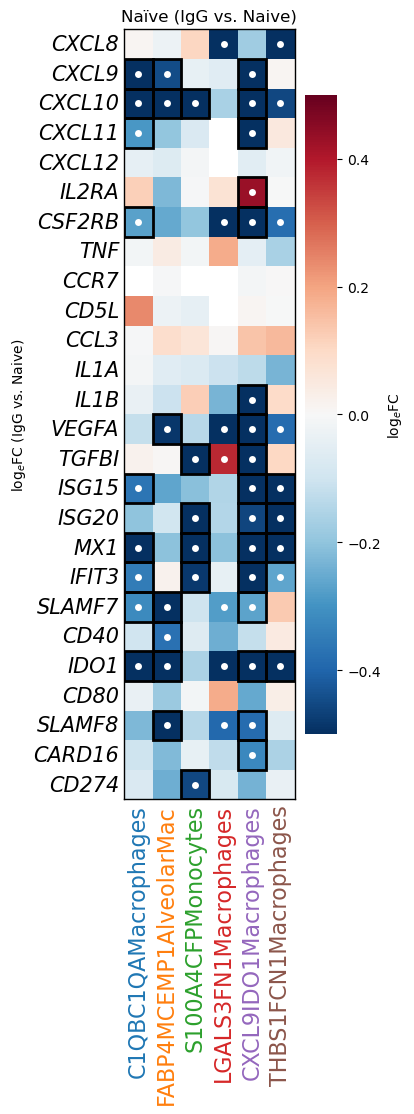

In [32]:
# naive vs igg macropahge plot
show_genes = ["CXCL8",'CXCL9',"CXCL10","CXCL11","CXCL12",
         "IL2RA","CSF2RB","TNF","CCR7","CD5L","CCL3",
              "IL1A","IL1B","VEGFA","TGFBI",
              "ISG15","ISG20","MX1","IFIT3",
              "SLAMF7" ,"CD40","IDO1" ,"CD80","SLAMF8" ,"CARD16","CD274"]

plot_group(allres_FC, issig, "Naïve", show_genes,save="./Figure5/NaivevsIgG_DE_genes_for_Publication_Macrophages.png",flip_direction=True)


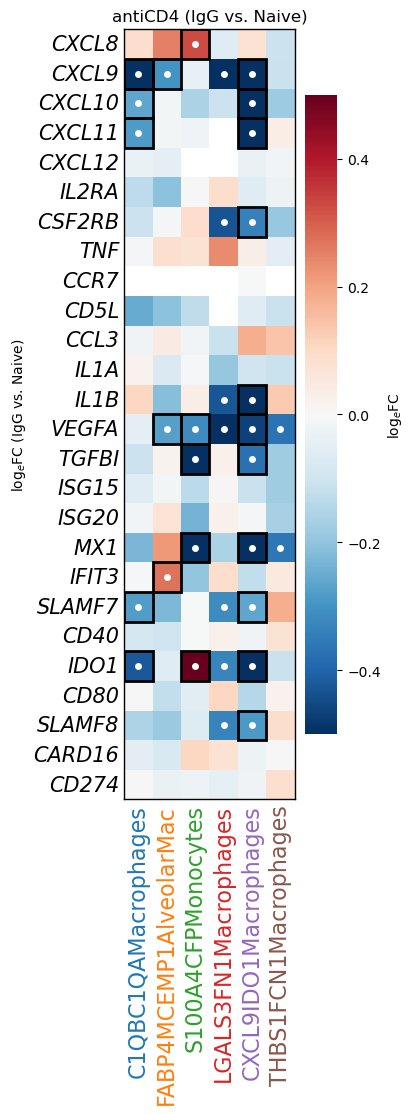

In [33]:
# antiCD4 vs igg macropahge plot
#note this is antiCD4 vs IgG (not IgG vs naive)
show_genes = ["CXCL8",'CXCL9',"CXCL10","CXCL11","CXCL12",
         "IL2RA","CSF2RB","TNF","CCR7","CD5L","CCL3",
              "IL1A","IL1B","VEGFA","TGFBI",
              "ISG15","ISG20","MX1","IFIT3",
              "SLAMF7" ,"CD40","IDO1" ,"CD80","SLAMF8" ,"CARD16","CD274"]

plot_group(allres_FC, issig, "antiCD4", show_genes,save="./Figure5/antiCD4vsIgG_DE_genes_for_Publication_Macrophages.png",flip_direction=True)


# Heatmaps for supplemental figure

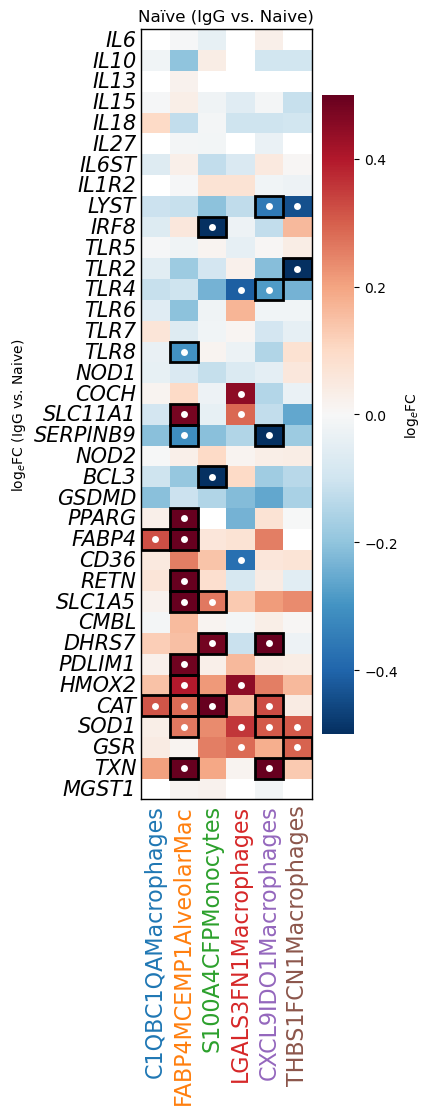

In [34]:
# naive vs igg macrophage supplmental figure heatmap
show_genes = ["IL6","IL10","IL13","IL15","IL18","IL27","IL6ST","IL1R2", "LYST","IRF8","TLR5","TLR2",
            "TLR4","TLR6","TLR7","TLR8","NOD1","COCH","SLC11A1","SERPINB9","NOD2","BCL3","GSDMD",
    "PPARG","FABP4","CD36","RETN","SLC1A5","CMBL","DHRS7","PDLIM1","HMOX2","CAT","SOD1","GSR","TXN","MGST1"]


plot_group(allres_FC, issig, "Naïve", show_genes,save="./Figure5/Macrophage_Associated_Supplemental_heatmap_NaivevIgG.png",flip_direction=True)


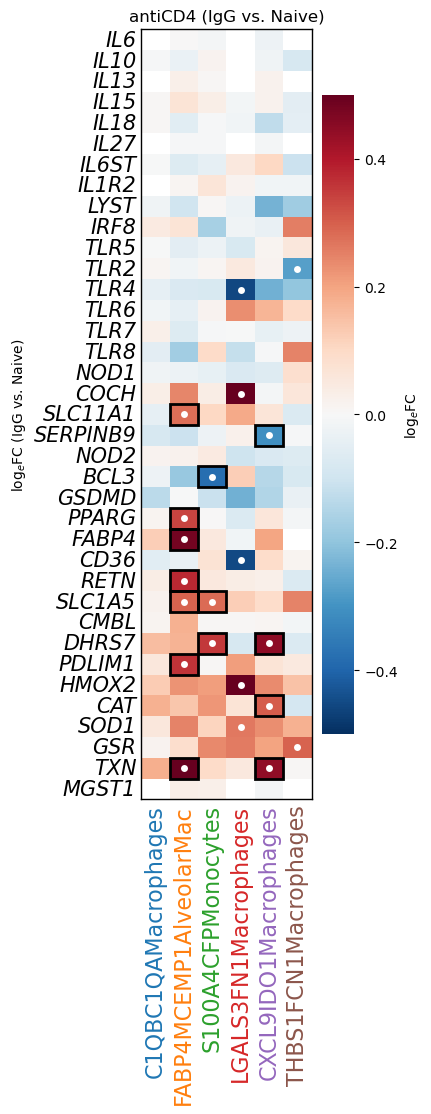

In [35]:
# aCD4 vs igg  macrophage supplmental figure heatmap
#note this is antiCD4 vs IgG 
#note the IgG vs Naive are hard coded and will need to be changed for each plot (should be IgG vs aCD4)
plot_group(allres_FC, issig, "antiCD4", show_genes,save="./Figure5/Macrophage_Associated_Supplemental_heatmap_aCD4evIgG.png",flip_direction=True)


# Supplemental (Figure 5 associated) Extract number of DE genes per condtion

In [4]:
# MAST DE results
file_path = './Figure5/Excel_sheets/MAST_DE_Macrophage_Outputs/DE_Stage/results/AllCT.AllPeriod.DE.Merged.csv'
allres = pd.read_csv(file_path, header=[0,1,2], index_col=0)

# reindex columns to specific cell types
allres = allres.reindex(columns=['CXCL9IDO1Macrophages',
 'FABP4MCEMP1AlveolarMac',
 'S100A4CFPMonocytes',
'C1QBC1QAMacrophages',
 'THBS1FCN1Macrophages',
 'LGALS3FN1Macrophages'], level=0)

# define thresholds
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)

allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

# determine significant DE genes
issig = (allres_Q < q_thresh) & (allres_FC.abs() > log_FC_thresh)
issig2 = (allres_Q < q_thresh) & (allres_FC < -log_FC_thresh)
issig1 = (allres_Q < q_thresh) & (allres_FC > log_FC_thresh)

# annotate based on directionality (logFC values)
allres['up_in_Naïve'] = issig1.sum(axis=1)
allres['up_in_IgG'] = issig2.sum(axis=1)

# DF w/ significant DE genes
dfT_up = pd.DataFrame(issig1.sum(axis=0), columns=['Naïve'])
dfT_down = pd.DataFrame(issig2.sum(axis=0), columns=['IgG'])

dfT_combined = pd.concat([dfT_up, dfT_down], axis=1).fillna(0).reset_index()
df_naive = dfT_combined[dfT_combined['level_1'] == 'Naïve'].copy()
df_anticd4 = dfT_combined[dfT_combined['level_1'] == 'antiCD4'].copy()

# rename cols
df_naive.columns = ['Celltype', 'Comparison', 'Naïve', 'IgG']
df_anticd4.columns = ['Celltype', 'Comparison', 'antiCD4', 'IgG']

# drop 'comparison' column
df_naive.drop(columns=['Comparison'], inplace=True)
df_anticd4.drop(columns=['Comparison'], inplace=True)

# define cell type order and re-annotate (latex format)
celltype_order = [
     'CXCL9IDO1Macrophages',
 'FABP4MCEMP1AlveolarMac',
 'S100A4CFPMonocytes',
'C1QBC1QAMacrophages',
 'THBS1FCN1Macrophages',
 'LGALS3FN1Macrophages',
]
celltype_annotations = {
'C1QBC1QAMacrophages':'C1QB$^{hi}$, C1QA$^{hi}$ Mφ',
 'FABP4MCEMP1AlveolarMac':'FABP4$^{hi}$, MCEMP1$^{hi}$ Alveolar Mφ',
 'S100A4CFPMonocytes':'S100A4$^{hi}$, CFP$^{hi}$ Monocytes',
 'LGALS3FN1Macrophages':'LGALS3$^{hi}$, FN1$^{hi}$ Mφ',
 'CXCL9IDO1Macrophages':'CXCL9$^{hi}$, IDO1$^{hi}$ Mφ',
 'THBS1FCN1Macrophages':'THBS1$^{hi}$, FCN1$^{hi}$ Mφ'
}

df_naive['Celltype'] = pd.Categorical(df_naive['Celltype'], categories=celltype_order, ordered=True)
df_anticd4['Celltype'] = pd.Categorical(df_anticd4['Celltype'], categories=celltype_order, ordered=True)

df_naive.sort_values('Celltype', inplace=True)
df_anticd4.sort_values('Celltype', inplace=True)

df_naive['Celltype'] = df_naive['Celltype'].map(celltype_annotations)
df_anticd4['Celltype'] = df_anticd4['Celltype'].map(celltype_annotations)

import matplotlib.patches as patches
def plot_de_genes(df, group1, group2, plot_path, sum_group1, sum_group2):
    '''
    NOTE: the allres_FC is the |FC|
    '''
    df_melted = df.melt(id_vars=['Celltype'], value_vars=[group1, group2], var_name='Group', value_name='Value')
    fig, ax = plt.subplots(figsize=(10, 6))
    fg = sns.barplot(x='Celltype', y='Value', hue='Group', data=df_melted, palette=reinfection_palette, edgecolor='white')
    patch_positions = [i for i in range(len(df['Celltype'])) if i % 2 == 0]
    for pos in patch_positions:
        ax.add_patch(patches.Rectangle((pos - 0.5, ax.get_ylim()[0]), 1, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    plt.xticks(rotation=90, size=12)
    fg.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.tick_right()
    plt.yticks(size=12, rotation=0)
    plt.grid(False)
    plt.ylabel("Granuloma: #DE Genes\n (FDR<0.05, logFC>1.3)", size=14)
    plt.xlabel("")
    plt.legend(title="Group", fontsize=12, title_fontsize=14)
    sns.despine(left=False, bottom=False, right=False, top=False)
    for p in fg.patches:
        fg.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points', rotation=90)
    ax.text(len(df['Celltype']) - 0.1, ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15, 
            f'Sum {group1}: {sum_group1}\nSum {group2}: {sum_group2}', fontsize=12, 
            verticalalignment='top', rotation=90)
    plt.savefig(plot_path, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

sum_naive = df_naive['Naïve'].sum()
sum_igG_naive = df_naive['IgG'].sum()

sum_anticd4 = df_anticd4['antiCD4'].sum()
sum_igG_anticd4 = df_anticd4['IgG'].sum()

os.makedirs('./Figure5/', exist_ok=True)


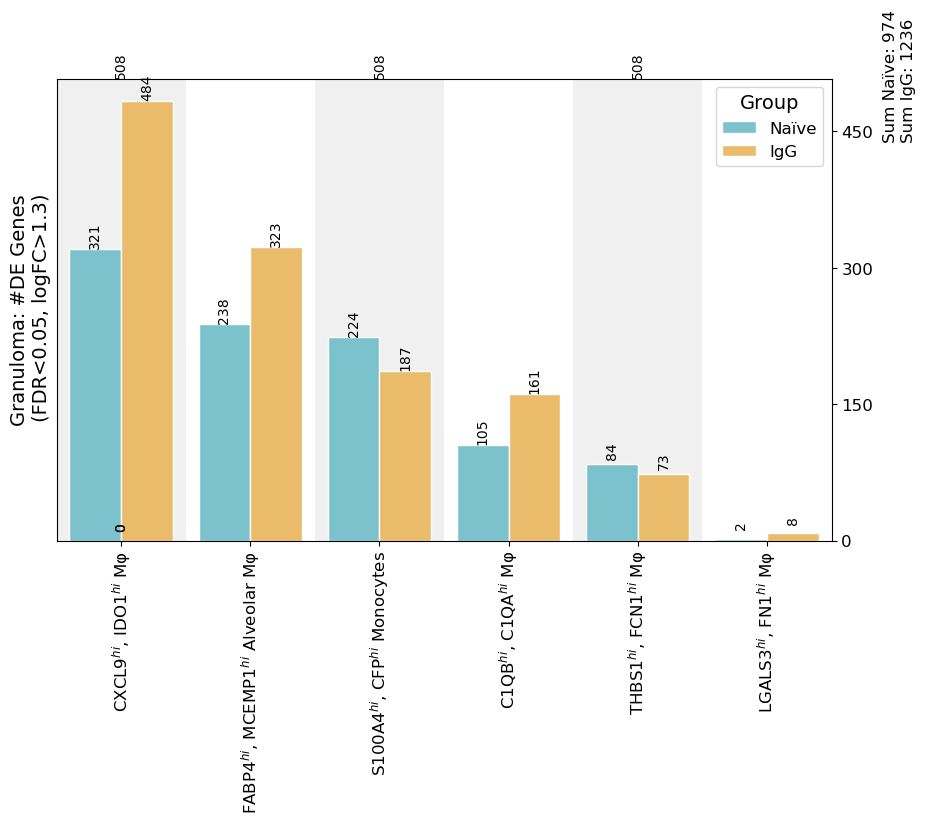

In [6]:
# Plot Naïve vs. IgG DE genes
plot_path_naive_vs_igg = './Figure5/Macrophage_Associated_Supplemental_NumDEgenes_NaivevIgG.png'
plot_de_genes(df_naive, 'Naïve', 'IgG', plot_path_naive_vs_igg, sum_naive, sum_igG_naive)

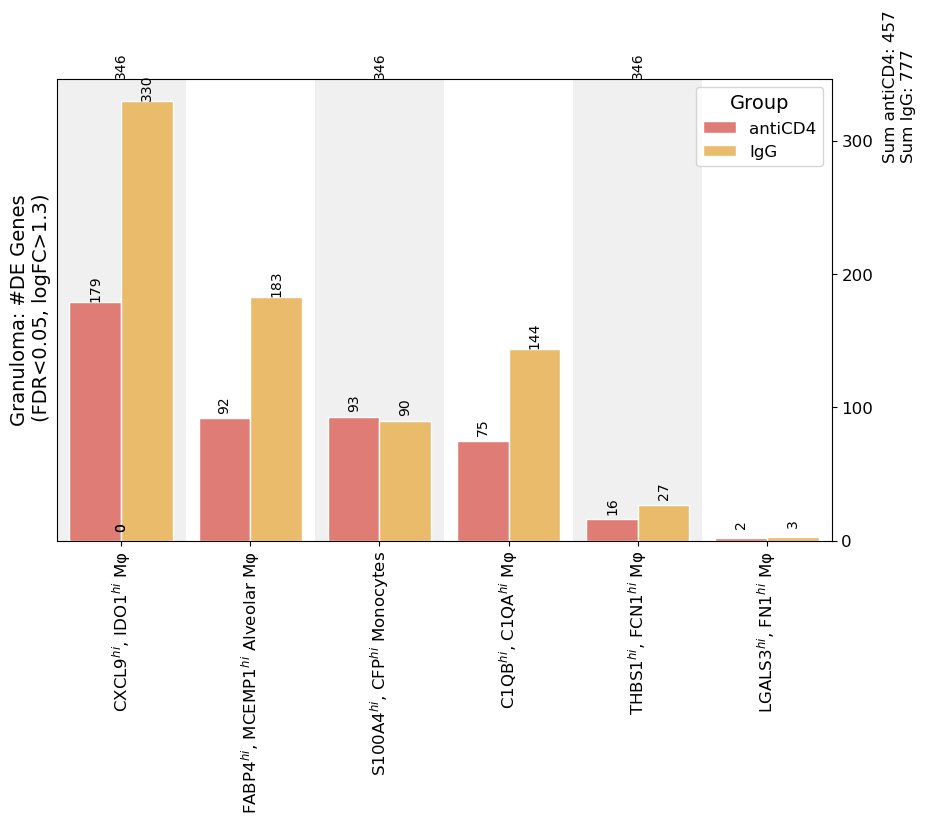

In [7]:
# Plot antiCD4 vs. IgG DE genes
plot_path_anticd4_vs_igg = './Macrophages_Associated_Supplemental_NumDEgenes_aCD4vIgG.png'
plot_de_genes(df_anticd4, 'antiCD4', 'IgG', plot_path_anticd4_vs_igg, sum_anticd4, sum_igG_anticd4)